### Local Modelling
- given the locale's relative SST in the two months leading up to cyclone genesis 
- test two lags (that month and the previous month) to see how 'predictable' it is

In [2]:
import numpy as np
import pandas as pd
from utils.jtwc_cyclone_utils import get_all_cyclones
cyclone_df = get_all_cyclones(one_per_id=True)
cyclone_df


timestamp   Storm ID BASIN  Season  SEASON TC NUMBER  \
911   1982-03-14 06:00:00   1982-N-1    WP  1982.0               1.0   
0     1981-10-21 06:00:00   1982-S-2    SI  1982.0               2.0   
912   1982-03-18 06:00:00   1982-N-2    WP  1982.0               2.0   
1     1981-11-03 18:00:00   1982-S-3    SI  1982.0               3.0   
913   1982-03-28 06:00:00   1982-N-3    WP  1982.0               3.0   
...                   ...        ...   ...     ...               ...   
1877  2022-10-14 06:00:00  2022-N-24    WP  2022.0              24.0   
1878  2022-10-26 00:00:00  2022-N-26    WP  2022.0              26.0   
1879  2022-10-28 12:00:00  2022-N-27    WP  2022.0              27.0   
1880  2022-11-11 18:00:00  2022-N-28    WP  2022.0              28.0   
1881  2022-12-08 00:00:00  2022-N-29    WP  2022.0              29.0   

      Latitude (degrees)  Longitude (degrees)  VMAX (kt)  Peak VMAX (kt)  \
911                  7.1                153.0       15.0            60.0   
0                   -8.0                 84.6       40.0            85.0   
912                  3.8                160.7       25.0           105.0   
1                   -8.6                 92.9       55.0            80.0   
913                  3.5                156.6       20.0            75.0   
...                  ...                  ...        ...             ...   
1877                26.4                154.4       25.0            40.0   
1878                12.2                133.8       20.0            75.0   
1879                 8.0                140.4       25.0            40.0   
1880                20.2                166.3       20.0            40.0   
1881                 6.4                133.1       15.0            50.0   

          ACE  Maximum 24h Intensification  
911   0.73250                         15.0  
0     1.18725                         25.0  
912   2.02800                         25.0  
1     1.08875                         15.0  
913   0.70650                         15.0  
...       ...                          ...  
1877  0.19675                         15.0  
1878  0.67825                         25.0  
1879  0.10875                         15.0  
1880  0.10600                         10.0  
1881  0.17550                         20.0  

[1882 rows x 11 columns]

## Obtaining some SST Variables

- Global 12 month rolling tropical mean -- how much energy is in the global atmosphere right now??
- Local monthly anomaly 

In [3]:
from utils.globals import SI_MIN, SI_MAX, SP_MIN, SP_MAX
from utils.SST_utils import get_historical_ssts, get_tropical_avg
import seaborn as sns
import matplotlib.pyplot as plt

historical_ssts = get_historical_ssts()
# Remove seasonality if possible...
tropical_avg_ssts = get_tropical_avg(historical_ssts)
tropical_avg_ssts
# historical_ssts # 0.2 degree grid
# historical_ssts['rSST'] = historical_ssts['sst'] - tropical_avg_ssts['sst'] don't use rSST


<xarray.Dataset>
Dimensions:  (time: 499)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
Data variables:
    sst      (time) float32 26.47 26.77 26.83 26.86 ... 27.14 27.15 27.3 27.8

#### For each cyclone entry, obtain the smoothed local rSST both in the month of genesis and the preceding month

In [4]:
from utils.cyclone_utils import get_datetime
from utils.SST_utils import get_local_smooth_at_time, sel_mm_yyyyy, get_local_mean


def filter_nan_from_values(list_obj):
    if len(list_obj) == 0:
        return np.nan
    
    return list_obj[0]


## EFFICIENCY CONCERNS???

def curried_local_smooth(lat, lon, time):
    return get_local_smooth_at_time(historical_ssts['sst'], lat,lon, time) 

def curried_local_mean_for_month(lat, lon, time):
    return get_local_mean(historical_ssts['sst'], lat,lon, time) 

months = range(1,13)
month_average_tropical_sst = {}

for month in months:
    tropical_ssts_for_month = tropical_avg_ssts['sst'].sel(time=tropical_avg_ssts.time.dt.month == month)
    month_average_tropical_sst[month] = tropical_ssts_for_month.mean().values
# def curried_local_smooth(lat, lon, time):
#     return get_local_smooth_at_time(historical_ssts['sst'], lat,lon, time) 

local_smooth_vectorized = np.vectorize(curried_local_smooth)
local_mean_for_month_vectorized = np.vectorize(curried_local_mean_for_month)

## TROPICAL SST IS SEASONALLY VARYING -- SHOULD CHANGE THIS SOMEHOW????
## WHY??? 
cyclone_df['Month'] = cyclone_df['timestamp'].apply(lambda x: get_datetime(x).month)
cyclone_df['Tropical SST'] = cyclone_df.apply(
    lambda row: filter_nan_from_values(tropical_avg_ssts['sst'].sel(time=sel_mm_yyyyy(tropical_avg_ssts, get_datetime(row['timestamp']).month, get_datetime(row['timestamp']).year)).values), axis=1)

cyclone_df['Tropical Anomaly'] = cyclone_df.apply(lambda row: row['Tropical SST'] - month_average_tropical_sst[row['Month']], axis = 1)
## GET TROPICAL ANOMALY FOR THAT MONTH....
cyclone_df['Local SST'] = local_smooth_vectorized(cyclone_df['Latitude (degrees)'], cyclone_df['Longitude (degrees)'], cyclone_df['timestamp'])
cyclone_df['Relative SST'] = cyclone_df['Local SST'] - cyclone_df['Tropical SST']
cyclone_df = cyclone_df.loc[(cyclone_df.loc[:,'Relative SST'] >= 0)]
## summary statistics
for var_name in ['Tropical SST', 'Local SST', 'Relative SST']:
    print(var_name + ': ')
    print('min: ' + str(cyclone_df[var_name].min()))
    print('max: ' + str(cyclone_df[var_name].max()))







Tropical SST: 
min: 26.1489
max: 28.371914
Local SST: 
min: 26.402126
max: 31.388695
Relative SST: 
min: 0.024908066
max: 4.2338123


In [5]:
## HOW DO WE FILTER OUR CYCLONE SEASONS?? POSITIVE RSST?


cyclone_df = cyclone_df.loc[(cyclone_df.loc[:,'Relative SST'] >= 0)]
cyclone_df = cyclone_df.dropna(subset=['Tropical SST', 'Local SST', 'Relative SST'], how='any')
cyclone_df
# cyclone_df.to_csv('../cyclone_data/jtwc/cleaned/full_cleaned.csv', index=False)

timestamp   Storm ID BASIN  Season  SEASON TC NUMBER  \
911   1982-03-14 06:00:00   1982-N-1    WP  1982.0               1.0   
0     1981-10-21 06:00:00   1982-S-2    SI  1982.0               2.0   
912   1982-03-18 06:00:00   1982-N-2    WP  1982.0               2.0   
1     1981-11-03 18:00:00   1982-S-3    SI  1982.0               3.0   
913   1982-03-28 06:00:00   1982-N-3    WP  1982.0               3.0   
...                   ...        ...   ...     ...               ...   
1877  2022-10-14 06:00:00  2022-N-24    WP  2022.0              24.0   
1878  2022-10-26 00:00:00  2022-N-26    WP  2022.0              26.0   
1879  2022-10-28 12:00:00  2022-N-27    WP  2022.0              27.0   
1880  2022-11-11 18:00:00  2022-N-28    WP  2022.0              28.0   
1881  2022-12-08 00:00:00  2022-N-29    WP  2022.0              29.0   

      Latitude (degrees)  Longitude (degrees)  VMAX (kt)  Peak VMAX (kt)  \
911                  7.1                153.0       15.0            60.0   
0                   -8.0                 84.6       40.0            85.0   
912                  3.8                160.7       25.0           105.0   
1                   -8.6                 92.9       55.0            80.0   
913                  3.5                156.6       20.0            75.0   
...                  ...                  ...        ...             ...   
1877                26.4                154.4       25.0            40.0   
1878                12.2                133.8       20.0            75.0   
1879                 8.0                140.4       25.0            40.0   
1880                20.2                166.3       20.0            40.0   
1881                 6.4                133.1       15.0            50.0   

          ACE  Maximum 24h Intensification  Month  Tropical SST  \
911   0.73250                         15.0      3     27.237669   
0     1.18725                         25.0     10     26.766029   
912   2.02800                         25.0      3     27.237669   
1     1.08875                         15.0     11     26.829243   
913   0.70650                         15.0      3     27.237669   
...       ...                          ...    ...           ...   
1877  0.19675                         15.0     10     26.962795   
1878  0.67825                         25.0     10     26.962795   
1879  0.10875                         15.0     10     26.962795   
1880  0.10600                         10.0     11     27.142609   
1881  0.17550                         20.0     12     27.141811   

      Tropical Anomaly  Local SST  Relative SST  
911          -0.270336  28.082220      0.844551  
0            -0.146004  28.012896      1.246866  
912          -0.270336  29.003502      1.765833  
1            -0.228115  27.334639      0.505396  
913          -0.270336  28.872086      1.634417  
...                ...        ...           ...  
1877          0.050762  28.137896      1.175100  
1878          0.050762  29.645842      2.683046  
1879          0.050762  29.821840      2.859045  
1880          0.085251  28.148760      1.006151  
1881          0.112261  29.715696      2.573885  

[1859 rows x 16 columns]

In [6]:
from utils.jtwc_cyclone_utils import get_saffir_simpson_category

cyclone_df = cyclone_df.dropna(subset=['Tropical SST'], how='any')
cyclone_df['Saffir-Simpson Category'] = cyclone_df['Peak VMAX (kt)'].apply(get_saffir_simpson_category)

data_of_interest=cyclone_df.loc[:, [
    'BASIN','Tropical SST','Tropical Anomaly', 'Local SST', 'Relative SST', 'Peak VMAX (kt)', 'Saffir-Simpson Category','Month', 'Maximum 24h Intensification', 'ACE'
    ] ]
# cyclone_df.to_csv('../cyclone_data/jtwc/cleaned/full_sst_means.csv')



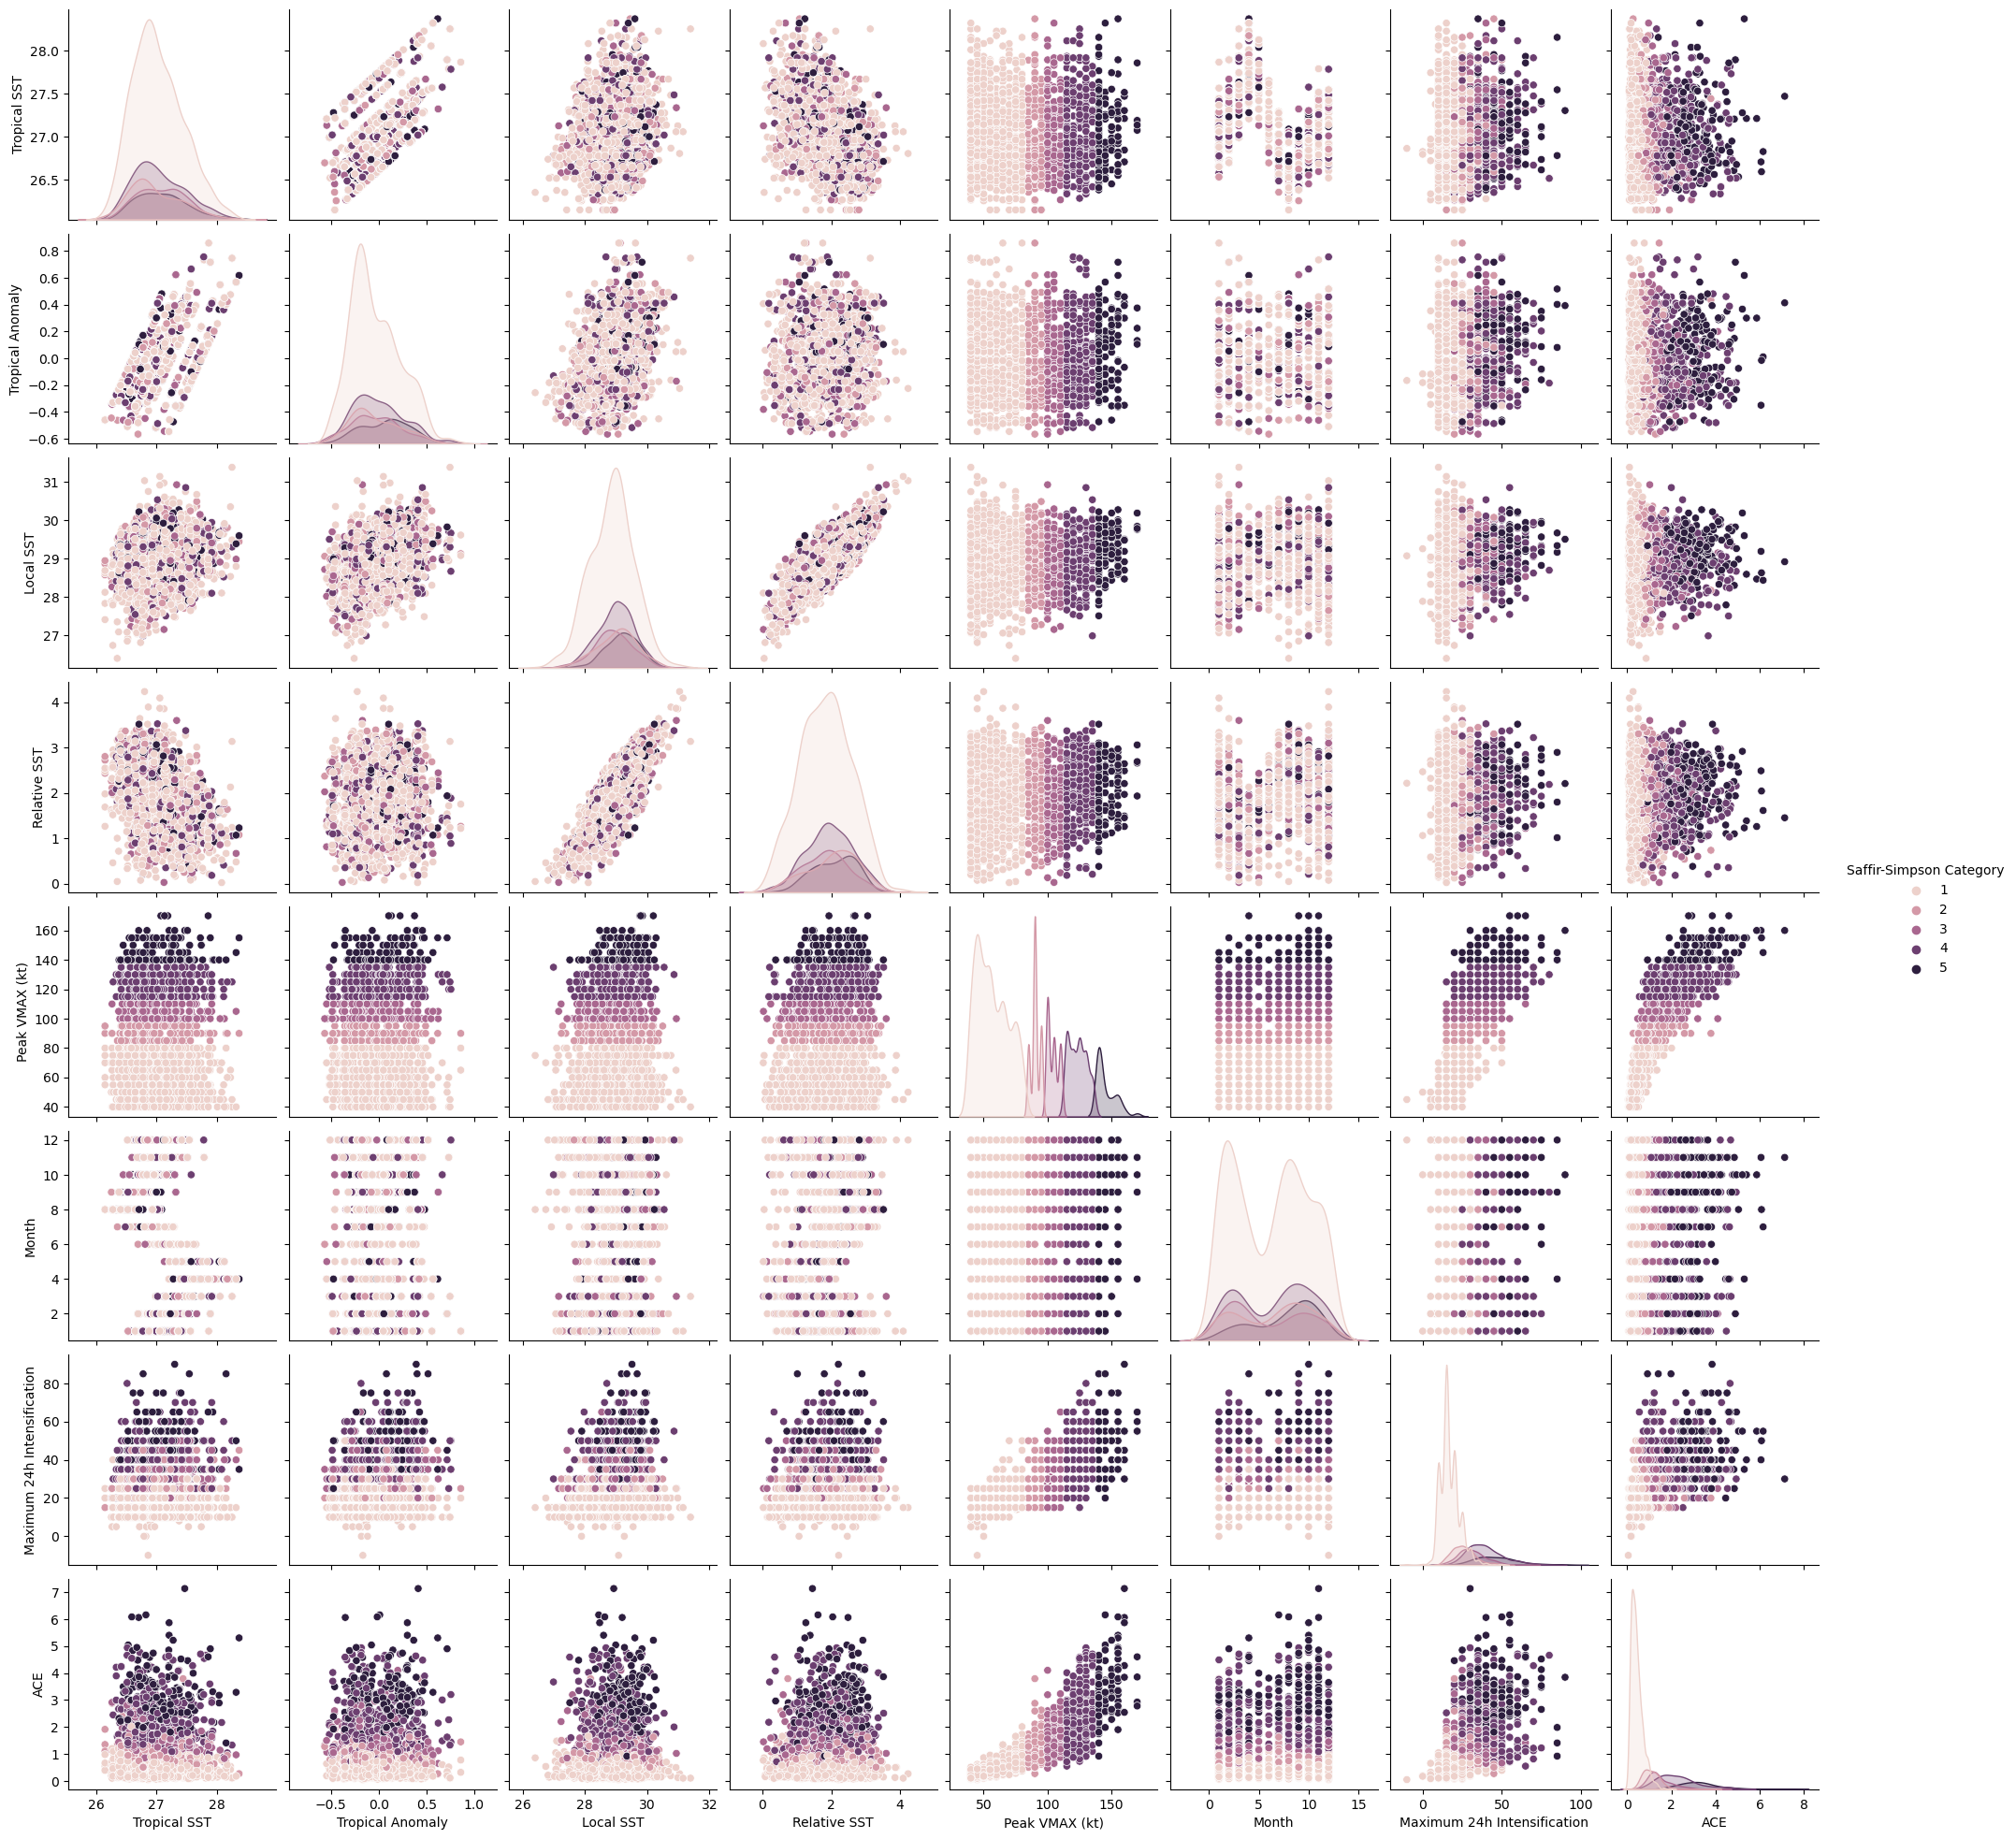

In [7]:

sns.pairplot(data=data_of_interest, hue='Saffir-Simpson Category')

In [8]:
basin_names = data_of_interest['BASIN'].unique()
print(basin_names)

print(data_of_interest.shape[0])

### SUMMARY STATISTICS
for basin_name in basin_names:
    print(f'basin: {basin_name}')
    basin_df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]

    for category in range(1,6):
        category_df = basin_df.loc[basin_df.loc[:, 'Saffir-Simpson Category'] == category]
        print(f'proportion of category {category} cyclones: {category_df.shape[0]/basin_df.shape[0]}')

print('Maximum 24h Intensification')
print(f'min: {data_of_interest["Maximum 24h Intensification"].min()}')
print(f'max: {data_of_interest["Maximum 24h Intensification"].max()}')

print('ACE')
print(f'min: {data_of_interest["ACE"].min()}')
print(f'max: {data_of_interest["ACE"].max()}')
    



# for basin_name in basin_names:
#     sns.pairplot(data= data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name], hue='Saffir-Simpson Category')
# # 




['WP' 'SI' 'SP']
1859
basin: WP
proportion of category 1 cyclones: 0.5062111801242236
proportion of category 2 cyclones: 0.11490683229813664
proportion of category 3 cyclones: 0.08385093167701864
proportion of category 4 cyclones: 0.17391304347826086
proportion of category 5 cyclones: 0.12111801242236025
basin: SI
proportion of category 1 cyclones: 0.5986277873070326
proportion of category 2 cyclones: 0.09090909090909091
proportion of category 3 cyclones: 0.11149228130360206
proportion of category 4 cyclones: 0.1646655231560892
proportion of category 5 cyclones: 0.03430531732418525
basin: SP
proportion of category 1 cyclones: 0.603225806451613
proportion of category 2 cyclones: 0.1032258064516129
proportion of category 3 cyclones: 0.11935483870967742
proportion of category 4 cyclones: 0.12258064516129032
proportion of category 5 cyclones: 0.05161290322580645
Maximum 24h Intensification
min: -10.0
max: 90.0
ACE
min: 0.0485
max: 7.13525


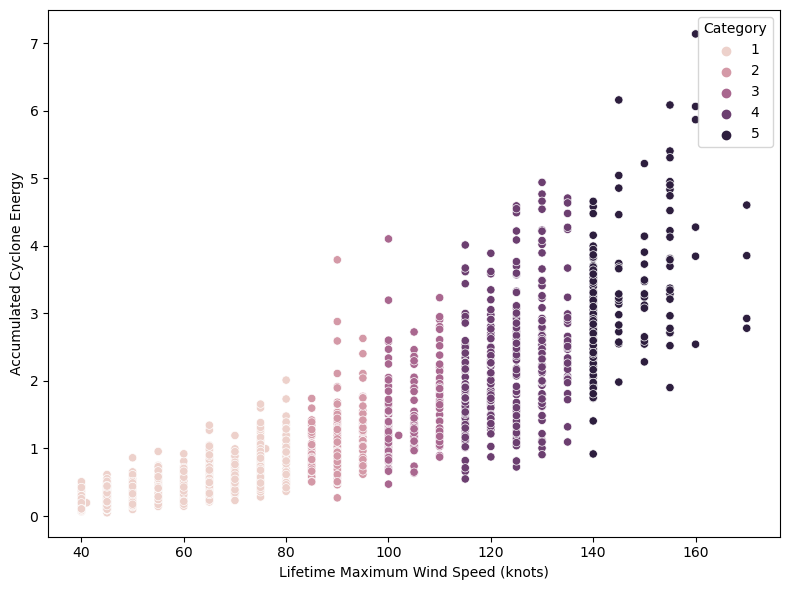

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(cyclone_df.assign(Category=cyclone_df['Saffir-Simpson Category']), x='Peak VMAX (kt)', y='ACE', hue='Category', ax=ax)
ax.set_xlabel('Lifetime Maximum Wind Speed (knots)')
ax.set_ylabel('Accumulated Cyclone Energy')
fig.tight_layout()
plt.show()
fig.savefig(f'./media/Cyclone/new_basins/cyclone_plot/vmax_ace_relation.png')

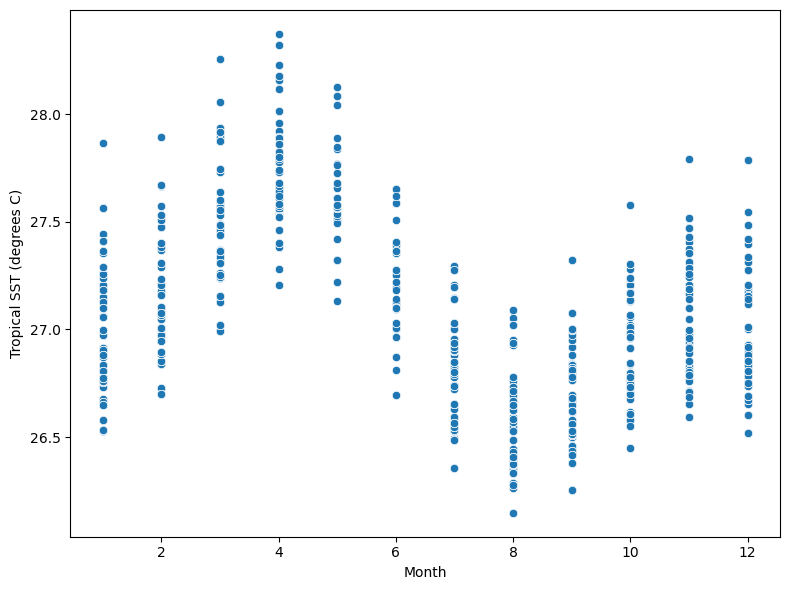

In [10]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data_of_interest, x='Month', y='Tropical SST', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel(r'Tropical SST (degrees C)')
fig.tight_layout()
plt.show()
fig.savefig(f'./media/SST/tropical_fluctuation.png')

WP
SI
SP


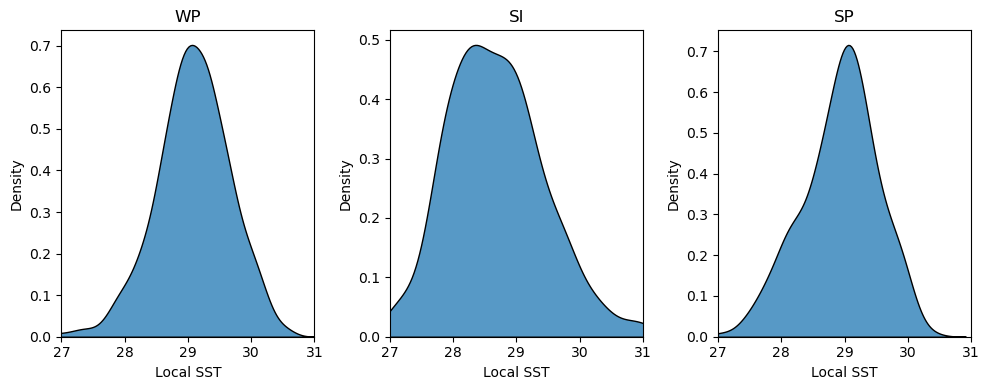

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

col = 0
for basin_name in basin_names:
    print(basin_name)
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Local SST',  ax=axs[col], multiple='stack').set(title=basin_name)
    axs[col].set_xbound(27,31)
    col += 1

plt.tight_layout()

# fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde.png')
plt.show()

WP
SI


SP


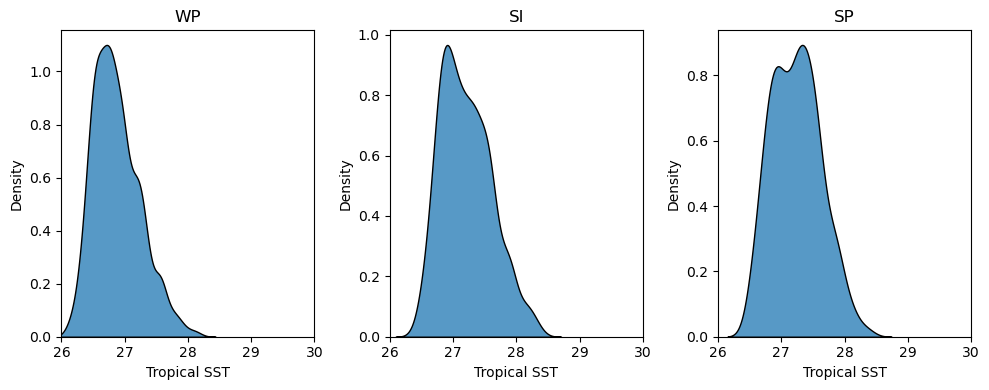

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

col = 0
for basin_name in basin_names:
    print(basin_name)
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Tropical SST',  ax=axs[col], multiple='stack').set(title=basin_name)
    axs[col].set_xbound(26,30)
    col += 1

plt.tight_layout()

# fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde.png')
plt.show()

WP
SI
SP


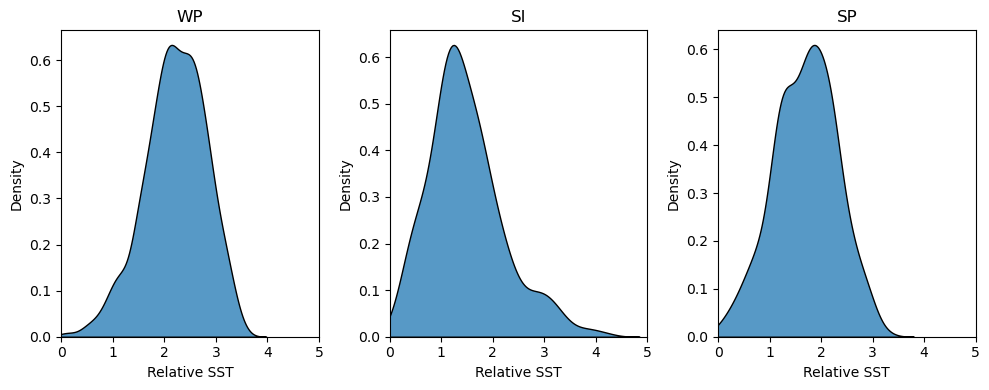

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

col = 0
for basin_name in basin_names:
    print(basin_name)
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Relative SST',  ax=axs[col], multiple='stack').set(title=basin_name)
    axs[col].set_xbound(0,5)
    col += 1

plt.tight_layout()

# fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde.png')
plt.show()

WP
SI
SP


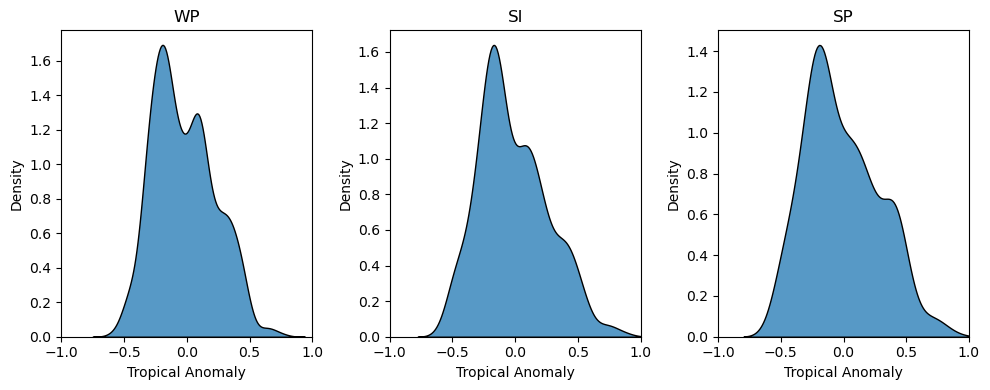

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

col = 0
for basin_name in basin_names:
    print(basin_name)
    df = data_of_interest.loc[data_of_interest.loc[:, 'BASIN'] == basin_name]
    sns.kdeplot(data=df, x='Tropical Anomaly',  ax=axs[col], multiple='stack').set(title=basin_name)
    axs[col].set_xbound(-1,1)
    col += 1

plt.tight_layout()

# fig.savefig('./media/cyclone_sst/new_basins/kde/local_kde.png')
plt.show()

number of real cyclones with season between 26.14889907836914 and 26.727206230163574: 465
number of real cyclones with season between 26.727206230163574 and 26.981508255004883: 465
number of real cyclones with season between 26.981508255004883 and 27.314990997314453: 467
number of real cyclones with season between 27.314990997314453 and 28.37191390991211: 465


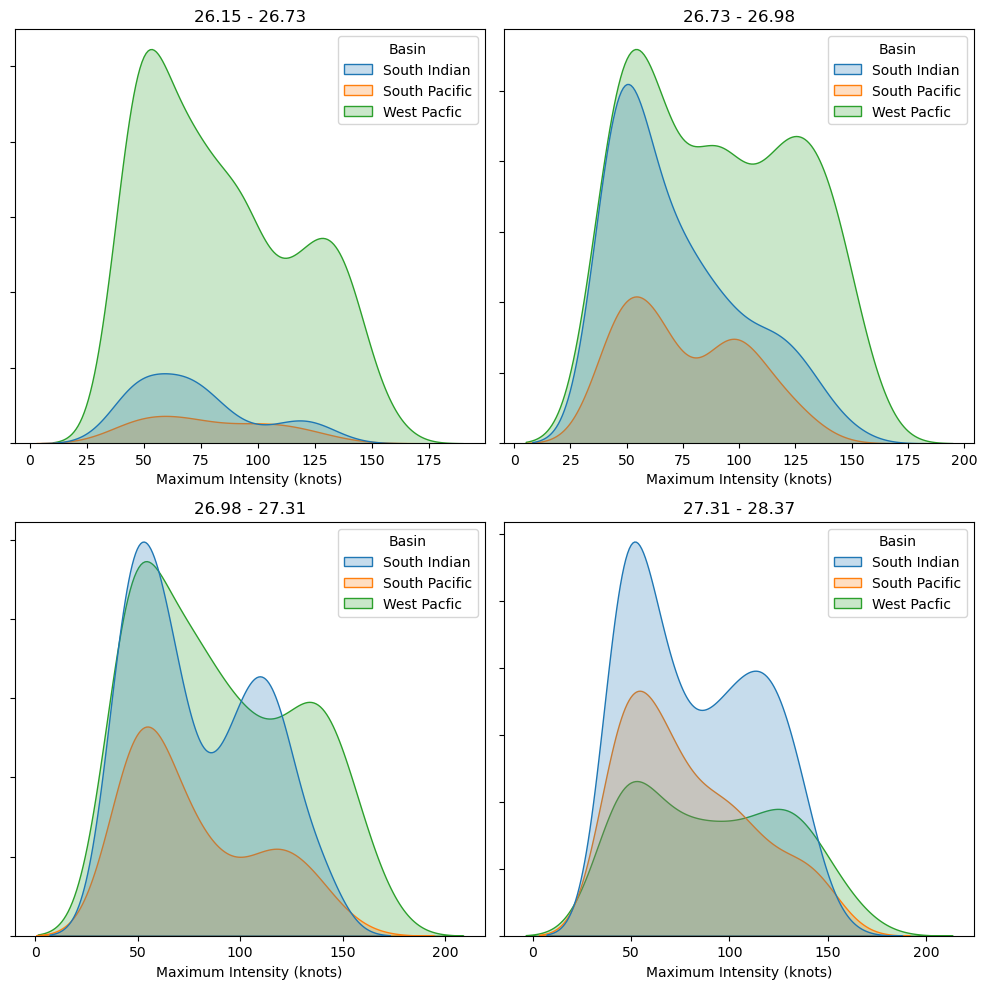

In [15]:
## examine changes in distribution over the decades??
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
row = 0
col = 0
data_of_interest = data_of_interest.assign(Basin = data_of_interest.BASIN.map({
    'WP': 'West Pacfic',
    'SI': 'South Indian',
    'SP': 'South Pacific'
})).sort_values(by='Basin')

# split into 4 quantiles
for (lower_p, upper_p) in [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]: 
    lower_q = data_of_interest['Tropical SST'].quantile(lower_p)
    upper_q = data_of_interest['Tropical SST'].quantile(upper_p)

    slice = data_of_interest.loc[(data_of_interest.loc[:, 'Tropical SST'] >= lower_q) & (data_of_interest.loc[:, 'Tropical SST'] <= upper_q)]

    print(f'number of real cyclones with season between {lower_q} and {upper_q}: {slice.shape[0]}')
    if row == 1 and col == 1:
        legend = 'default'
    else:
        legend = None
    
    ax = sns.kdeplot(data=slice, x='Peak VMAX (kt)', hue='Basin', common_norm=True, fill=True,  multiple='layer',ax=axs[row][col])
    ax.set_title(f'{(round(lower_q, 2))} - {(round(upper_q,2))}')
    ax.set_xlabel("Maximum Intensity (knots)")
    ax.set_ylabel('')
    ax.set_yticklabels([])

    col += 1
    if col == 2:
        col = 0;
        row += 1

plt.tight_layout()
plt.savefig('./media/Cyclone/new_basins/cyclone_plot/wind_kde_tropical_sst.png')
plt.show()

number of real cyclones with season between 26.40212631225586 and 28.497713088989258: 465
number of real cyclones with season between 28.497713088989258 and 28.966211318969727: 465
number of real cyclones with season between 28.966211318969727 and 29.36749267578125: 465
number of real cyclones with season between 29.36749267578125 and 31.388694763183594: 465


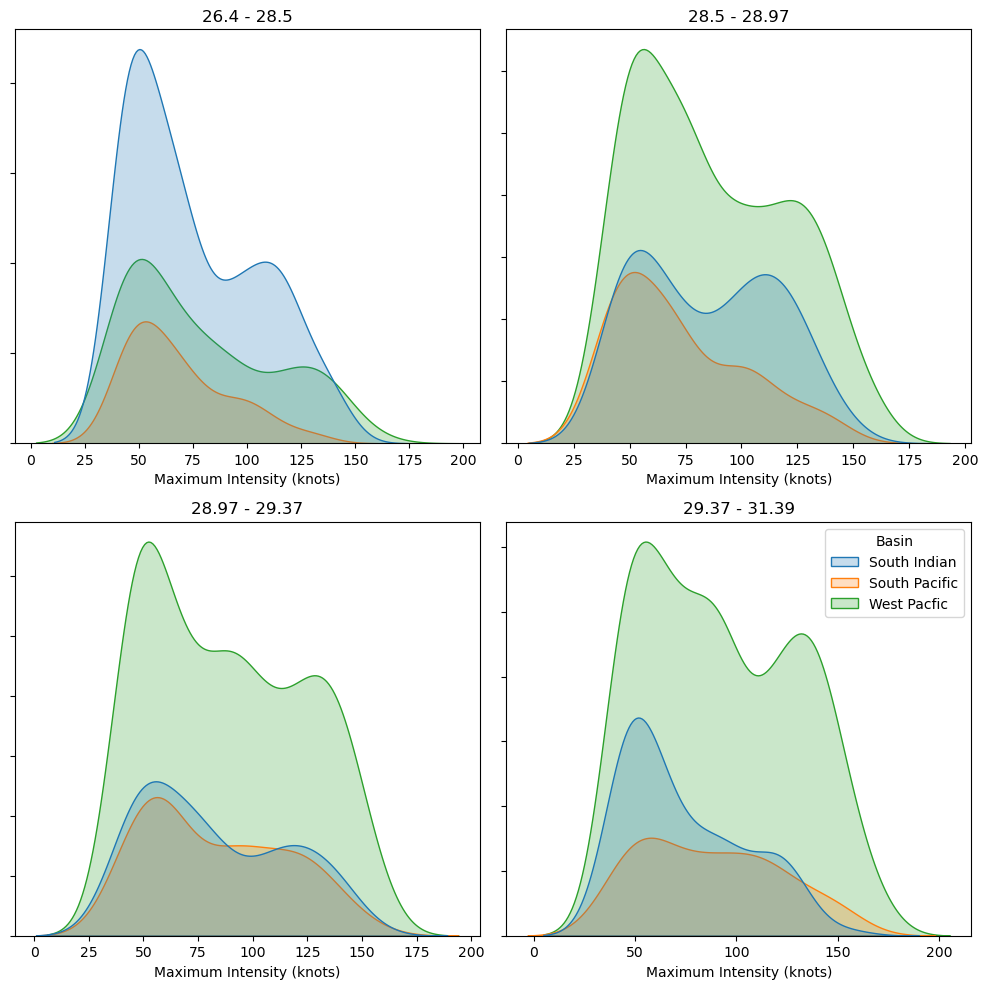

In [16]:
## examine changes in distribution over the decades??
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
row = 0
col = 0

# split into 4 quantiles
for (lower_p, upper_p) in [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]: 
    lower_q = data_of_interest['Local SST'].quantile(lower_p)
    upper_q = data_of_interest['Local SST'].quantile(upper_p)

    slice = data_of_interest.loc[(data_of_interest.loc[:, 'Local SST'] >= lower_q) & (data_of_interest.loc[:, 'Local SST'] <= upper_q)]

    print(f'number of real cyclones with season between {lower_q} and {upper_q}: {slice.shape[0]}')
    if row == 1 and col == 1:
        legend = 'default'
    else:
        legend = None
    
    ax = sns.kdeplot(data=slice, x='Peak VMAX (kt)', hue='Basin', common_norm=True, fill=True,  multiple='layer',ax=axs[row][col], legend=legend)
    ax.set_title(f'{(round(lower_q, 2))} - {(round(upper_q,2))}')
    ax.set_xlabel("Maximum Intensity (knots)")
    ax.set_ylabel('')
    ax.set_yticklabels([])

    col += 1
    if col == 2:
        col = 0;
        row += 1

plt.tight_layout()
plt.savefig('./media/Cyclone/new_basins/cyclone_plot/wind_kde_local_sst.png')
plt.show()

number of real cyclones with season between 0.024908065795898438 and 1.3609848022460938: 465
number of real cyclones with season between 1.3609848022460938 and 1.9115715026855469: 465
number of real cyclones with season between 1.9115715026855469 and 2.4241724014282227: 465
number of real cyclones with season between 2.4241724014282227 and 4.23381233215332: 465


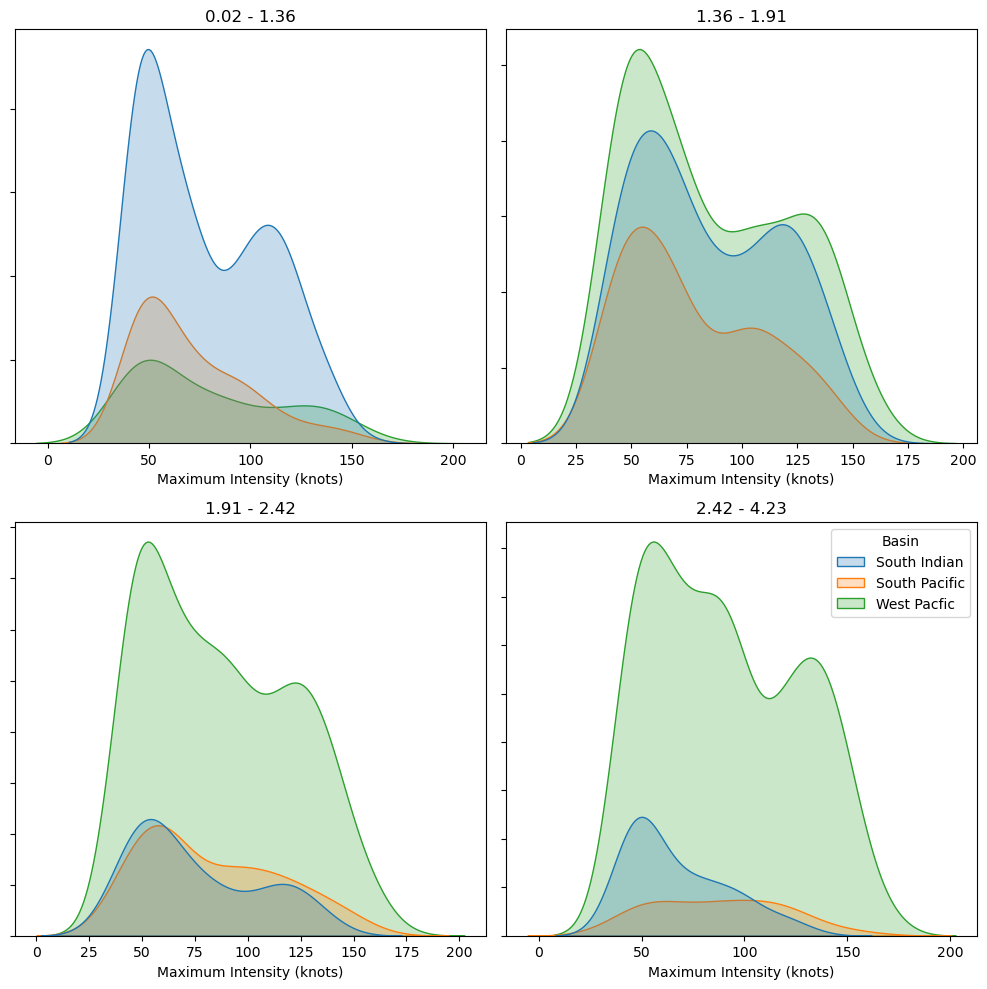

In [17]:
## examine changes in distribution over the decades??
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
row = 0
col = 0


# split into 4 quantiles
for (lower_p, upper_p) in [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]: 
    lower_q = data_of_interest['Relative SST'].quantile(lower_p)
    upper_q = data_of_interest['Relative SST'].quantile(upper_p)

    slice = data_of_interest.loc[(data_of_interest.loc[:, 'Relative SST'] >= lower_q) & (data_of_interest.loc[:, 'Relative SST'] <= upper_q)]

    print(f'number of real cyclones with season between {lower_q} and {upper_q}: {slice.shape[0]}')
    if row == 1 and col == 1:
        legend = 'default'
    else:
        legend = None
    
    ax = sns.kdeplot(data=slice, x='Peak VMAX (kt)', hue='Basin', common_norm=True, fill=True,  multiple='layer',ax=axs[row][col], legend=legend)
    ax.set_title(f'{(round(lower_q, 2))} - {(round(upper_q,2))}')
    ax.set_xlabel("Maximum Intensity (knots)")
    ax.set_ylabel('')
    ax.set_yticklabels([])

    col += 1
    if col == 2:
        col = 0;
        row += 1

plt.tight_layout()
plt.savefig('./media/Cyclone/new_basins/cyclone_plot/wind_kde_relative_sst.png')
plt.show()

number of real cyclones with season between -0.5654163360595703 and -0.2160358428955078: 466
number of real cyclones with season between -0.2160358428955078 and -0.07154083251953125: 467
number of real cyclones with season between -0.07154083251953125 and 0.14425086975097656: 470
number of real cyclones with season between 0.14425086975097656 and 0.8591289520263672: 466


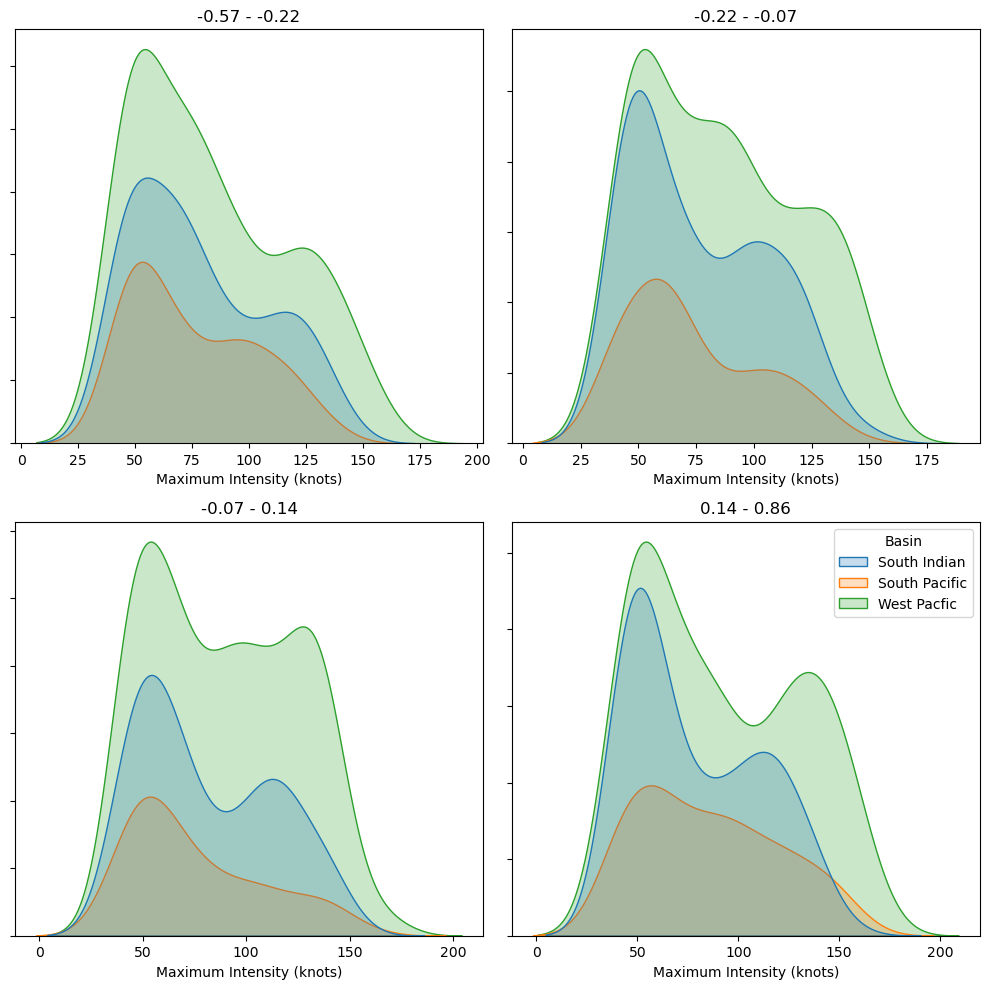

In [18]:
## examine changes in distribution over the decades??
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
row = 0
col = 0
data_of_interest = data_of_interest.assign(Basin = data_of_interest.BASIN.map({
    'WP': 'West Pacfic',
    'SI': 'South Indian',
    'SP': 'South Pacific'
}))

# split into 4 quantiles
for (lower_p, upper_p) in [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]: 
    lower_q = data_of_interest['Tropical Anomaly'].quantile(lower_p)
    upper_q = data_of_interest['Tropical Anomaly'].quantile(upper_p)

    slice = data_of_interest.loc[
        (data_of_interest.loc[:, 'Tropical Anomaly'] >= lower_q) & 
        (data_of_interest.loc[:, 'Tropical Anomaly'] <= upper_q)]

    print(f'number of real cyclones with season between {lower_q} and {upper_q}: {slice.shape[0]}')
    if row == 1 and col == 1:
        legend = 'default'
    else:
        legend = None
    
    ax = sns.kdeplot(data=slice, x='Peak VMAX (kt)', hue='Basin', common_norm=True, fill=True,  multiple='layer',ax=axs[row][col], legend=legend)
    ax.set_title(f'{(round(lower_q, 2))} - {(round(upper_q,2))}')
    ax.set_xlabel("Maximum Intensity (knots)")
    ax.set_ylabel('')
    ax.set_yticklabels([])

    col += 1
    if col == 2:
        col = 0;
        row += 1

plt.tight_layout()
plt.savefig('./media/Cyclone/new_basins/cyclone_plot/wind_kde_tropical_anomaly.png')
plt.show()

### TODO: effect of interaction between coordinates and lag 0 local rSST on cyclone severity.

In [19]:
## Rename columns for statsmodels
renamed_df = cyclone_df.copy()
renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
renamed_df

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_6347/409357478.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_6347/409357478.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  renamed_df.columns = renamed_df.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


timestamp   storm_id basin  season  season_tc_number  \
911   1982-03-14 06:00:00   1982-N-1    WP  1982.0               1.0   
0     1981-10-21 06:00:00   1982-S-2    SI  1982.0               2.0   
912   1982-03-18 06:00:00   1982-N-2    WP  1982.0               2.0   
1     1981-11-03 18:00:00   1982-S-3    SI  1982.0               3.0   
913   1982-03-28 06:00:00   1982-N-3    WP  1982.0               3.0   
...                   ...        ...   ...     ...               ...   
1877  2022-10-14 06:00:00  2022-N-24    WP  2022.0              24.0   
1878  2022-10-26 00:00:00  2022-N-26    WP  2022.0              26.0   
1879  2022-10-28 12:00:00  2022-N-27    WP  2022.0              27.0   
1880  2022-11-11 18:00:00  2022-N-28    WP  2022.0              28.0   
1881  2022-12-08 00:00:00  2022-N-29    WP  2022.0              29.0   

      latitude_degrees  longitude_degrees  vmax_kt  peak_vmax_kt      ace  \
911                7.1              153.0     15.0          60.0  0.73250   
0                 -8.0               84.6     40.0          85.0  1.18725   
912                3.8              160.7     25.0         105.0  2.02800   
1                 -8.6               92.9     55.0          80.0  1.08875   
913                3.5              156.6     20.0          75.0  0.70650   
...                ...                ...      ...           ...      ...   
1877              26.4              154.4     25.0          40.0  0.19675   
1878              12.2              133.8     20.0          75.0  0.67825   
1879               8.0              140.4     25.0          40.0  0.10875   
1880              20.2              166.3     20.0          40.0  0.10600   
1881               6.4              133.1     15.0          50.0  0.17550   

      maximum_24h_intensification  month  tropical_sst  tropical_anomaly  \
911                          15.0      3     27.237669         -0.270336   
0                            25.0     10     26.766029         -0.146004   
912                          25.0      3     27.237669         -0.270336   
1                            15.0     11     26.829243         -0.228115   
913                          15.0      3     27.237669         -0.270336   
...                           ...    ...           ...               ...   
1877                         15.0     10     26.962795          0.050762   
1878                         25.0     10     26.962795          0.050762   
1879                         15.0     10     26.962795          0.050762   
1880                         10.0     11     27.142609          0.085251   
1881                         20.0     12     27.141811          0.112261   

      local_sst  relative_sst  saffir-simpson_category  
911   28.082220      0.844551                        1  
0     28.012896      1.246866                        2  
912   29.003502      1.765833                        3  
1     27.334639      0.505396                        1  
913   28.872086      1.634417                        1  
...         ...           ...                      ...  
1877  28.137896      1.175100                        1  
1878  29.645842      2.683046                        1  
1879  29.821840      2.859045                        1  
1880  28.148760      1.006151                        1  
1881  29.715696      2.573885                        1  

[1859 rows x 17 columns]

## Quantile regression:
### Begin with all basins combined then split it up

 peak_vmax_kt  ~ tropical_sst
None


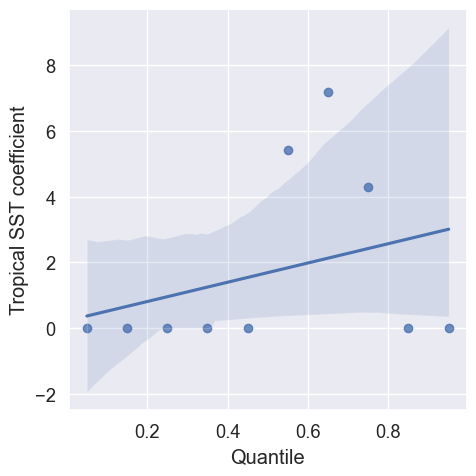

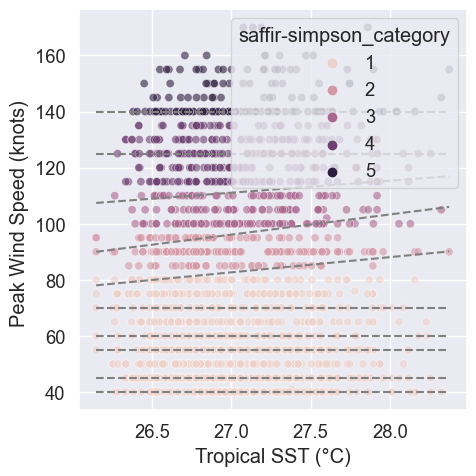

 peak_vmax_kt  ~ local_sst
None


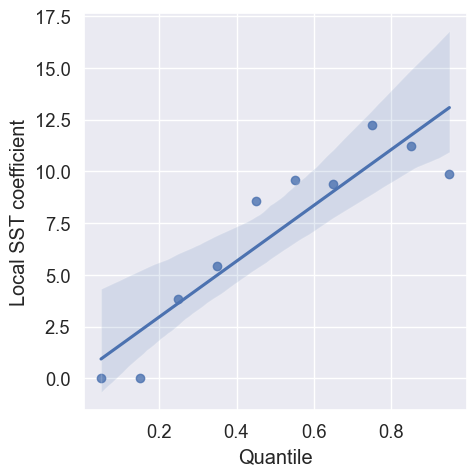

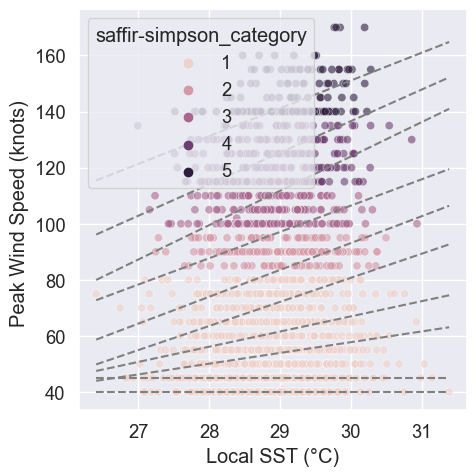

 peak_vmax_kt  ~ relative_sst
None


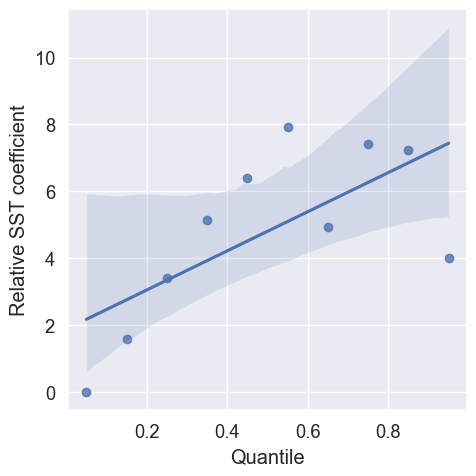

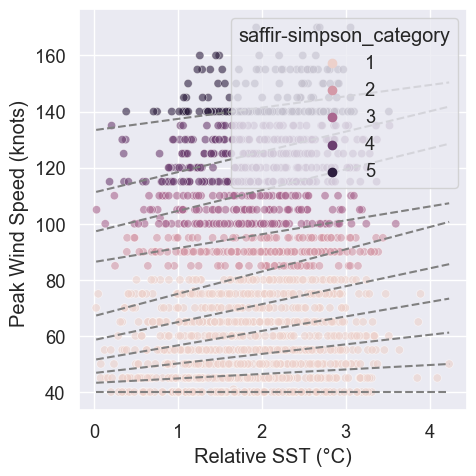

 peak_vmax_kt  ~ tropical_anomaly
None


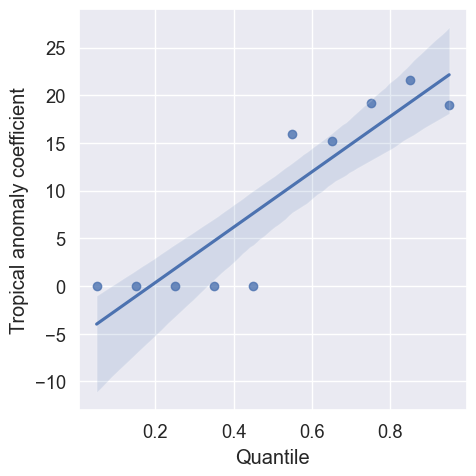

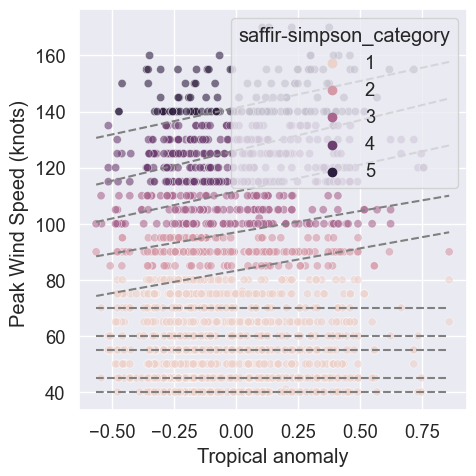

In [20]:
# basic logistic regressor on lag 0 sst smoothed 
# TODO: Quantile regression -> top 10% of cyclones will look like??
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import sklearn.metrics

## more regressions at higher quantiles
# quantiles = np.arange(0.09, 1, 0.1)
quantiles = np.arange(0.05, 0.96, 0.1)

def fit_model(quantile, model):
    res = model.fit(q=quantile)
    param_names = res.params.keys()
    # first one is intercept
    without_intercept = param_names[1:]
    ret_list = [quantile] + [res.params["Intercept"]] + [res.params[coefficient] for coefficient in without_intercept]
    for coefficient in without_intercept:
        ret_list += res.conf_int().loc[coefficient].tolist()

    return ret_list

def run_regression(df, response_var, ind_vars):
    model_string = f' {response_var}  ~ {" + ".join(ind_vars)}'
    print(model_string)
    model = smf.quantreg(f' {response_var}  ~ {" + ".join(ind_vars)}', data=df)
    models = [fit_model(x, model) for x in quantiles]
    models = pd.DataFrame(models, columns=["quantile"] + ["Intercept"] + [f"{var} Coefficient" for var in ind_vars] + [item for var in ind_vars for item in [f"{var} Lower", f"{var} Upper"]])
    return models



# for a single observation
def quantile_loss(y, y_pred, tau):
    return np.sum((abs(y - y_pred) + (2*tau - 1)*(y - y_pred))/2)


def get_loss(x, y, ind_var, models):
    loss = 0
    for quantile_index in range(models.shape[0]):
        y_pred = models["Intercept"][quantile_index] + models[f"{ind_var} Coefficient"][quantile_index] * x
        loss += quantile_loss(y, y_pred, quantiles[quantile_index])
    return loss/(models.shape[0]) ## take an average per quantile per observation


# FONT_SIZE = 16
sns.set(font_scale = 1.2)

def plot_coefficients(models, ind_var,  ax):
    plot =  sns.regplot(data=models, x="quantile", y=f"{ind_var} Coefficient", ax=ax)
    plot.set_xlabel( xlabel='Quantile')
    plot.set_ylabel(f"{ind_var}".capitalize().replace('_', ' ').replace('sst', 'SST')  + ' coefficient')
    return plot


def plot_fit(df, models, ind_var, all_vars, response_var, ax, add_legend = 'auto'):
    plot = sns.scatterplot(data=df, x=ind_var, y=response_var, hue='saffir-simpson_category', alpha=0.6, ax=ax, legend=add_legend)
    plot.set_ylabel(response_var.capitalize().replace('vmax', 'Wind Speed (knots)').replace('kt', '').replace('_', ' '))
    plot.set_xlabel(ind_var.capitalize().replace('sst', 'SST (°C)').replace('_', ' '))

    var_x = np.linspace(df[ind_var].min(), df[ind_var].max(), 100)
    for i in range(models.shape[0]):    
        y = models["Intercept"][i] + models[f"{ind_var} Coefficient"][i] * var_x
        for other_var in all_vars:
            if other_var == ind_var:
                continue
            else:
                y += df[other_var].mean() * models[f"{other_var} Coefficient"][i]

        ax.plot(var_x, y, linestyle="dashed", color="grey")
    
    return plot
    

# ONLY SET UP FOR ONE VARIABLE....        
def run_regression_and_plots(df, response_var, ind_vars,additional_title=None):
    models = run_regression(df, response_var, ind_vars)
    print(additional_title)
    [ind_var] = ind_vars

    # GO THROUGH FOR EACH VARIABE AND PLOT SEPARATELY
    fig, ax = plt.subplots(figsize = (5,5))
    plot_coefficients(models=models, ind_var = ind_var, ax = ax)
    fig.tight_layout()
    plt.savefig(f'./media/freq_quantreg/{ind_var}_{response_var}_coefficients_plot.png')
    plt.show()


    fig, ax = plt.subplots(figsize = (5,5))
    plot_fit(df, models, ind_var, ind_vars, response_var, ax)
    plt.tight_layout()
    plt.savefig(f'./media/freq_quantreg/{ind_var}_{response_var}_fit_plot.png')
    plt.show()

   
run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['tropical_sst'], additional_title=None)
run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['local_sst'],  additional_title=None)
run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['relative_sst'],  additional_title=None)
run_regression_and_plots(renamed_df, response_var='peak_vmax_kt', ind_vars=['tropical_anomaly'],  additional_title=None)


## INTERESTING: ALL BASINS HAVE POSTIVE TROPICAL SST, BUT PUTTING IT TOGETHER BRING IT TO ZERO???
##              THIS IS DUE TO THE SEASONALITY OF THE TROPICAL SST VARIABLE -- ITS LIKE A SINE WAVE




local_sst
 peak_vmax_kt  ~ local_sst
 peak_vmax_kt  ~ local_sst


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


 peak_vmax_kt  ~ local_sst


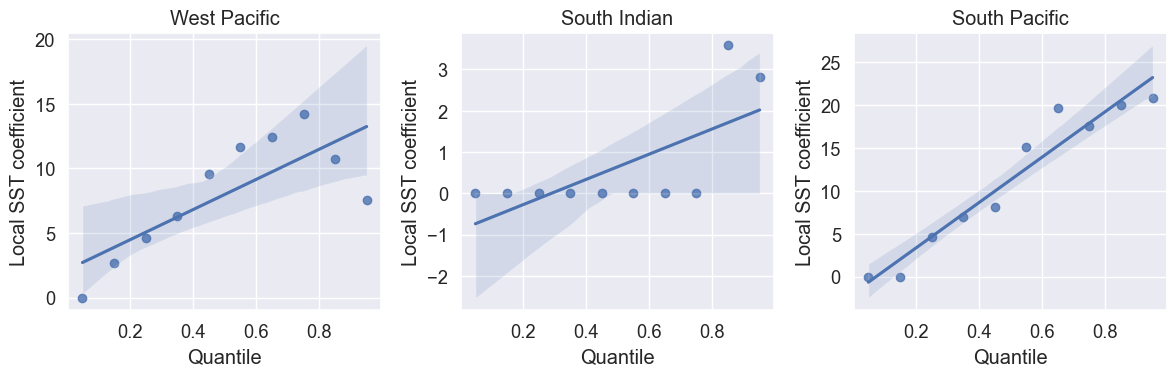

WP
 peak_vmax_kt  ~ local_sst
loss in basin: 10.024597240155774
SI
 peak_vmax_kt  ~ local_sst
loss in basin: 8.690935026924565
SP


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


 peak_vmax_kt  ~ local_sst
loss in basin: 8.39763675622017
total loss: 9.335042199631927


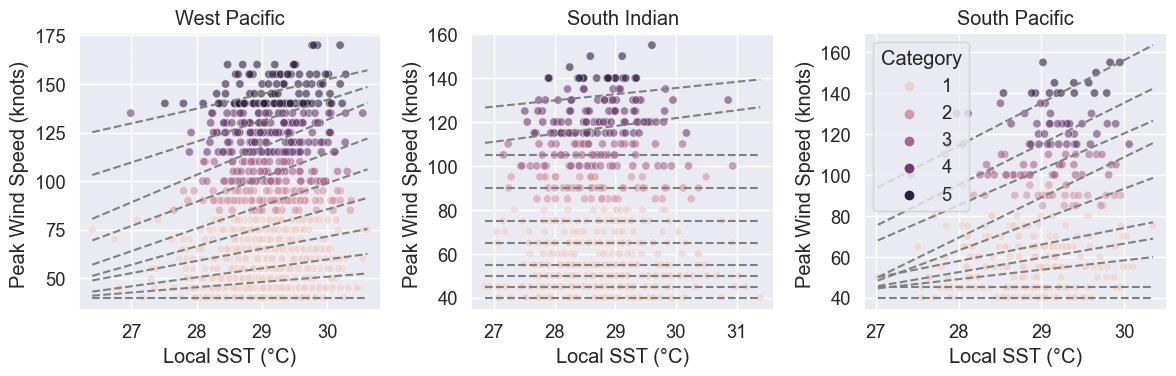

tropical_sst
 peak_vmax_kt  ~ tropical_sst
 peak_vmax_kt  ~ tropical_sst
 peak_vmax_kt  ~ tropical_sst


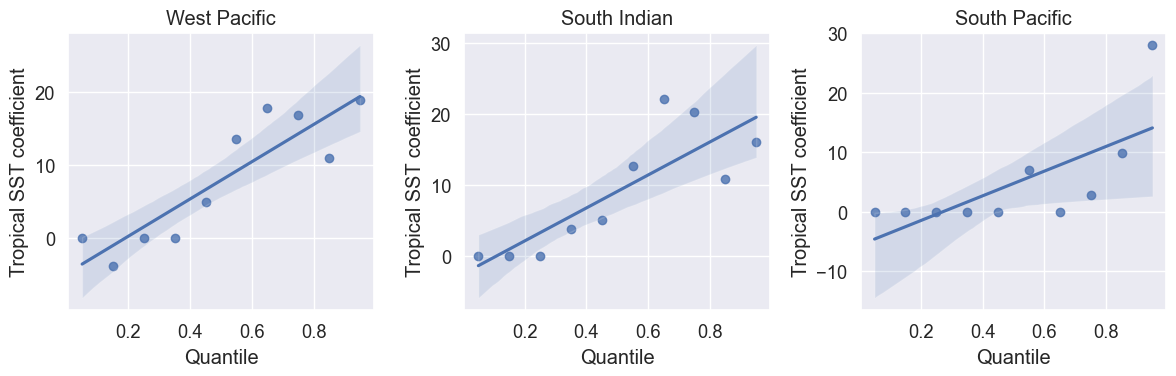

WP
 peak_vmax_kt  ~ tropical_sst
loss in basin: 10.058571508419437
SI
 peak_vmax_kt  ~ tropical_sst
loss in basin: 8.628200507123106
SP
 peak_vmax_kt  ~ tropical_sst
loss in basin: 8.607160276843654
total loss: 9.367961623780246


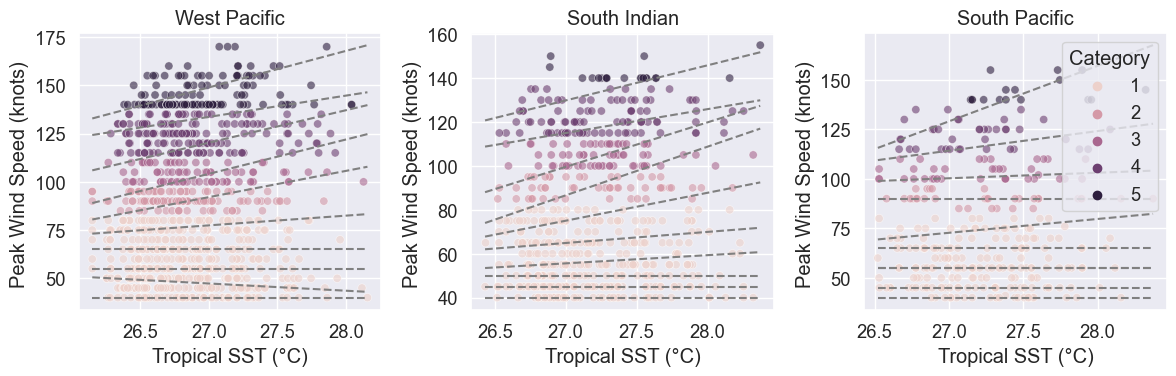

relative_sst
 peak_vmax_kt  ~ relative_sst
 peak_vmax_kt  ~ relative_sst
 peak_vmax_kt  ~ relative_sst


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


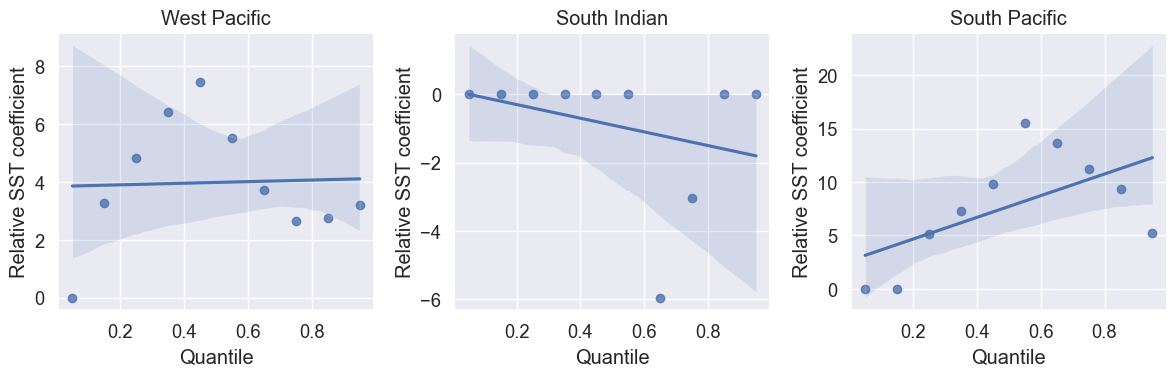

WP
 peak_vmax_kt  ~ relative_sst
loss in basin: 10.084903801687016
SI
 peak_vmax_kt  ~ relative_sst
loss in basin: 8.689587528758759
SP
 peak_vmax_kt  ~ relative_sst


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


loss in basin: 8.490574086343086
total loss: 9.381454851243877


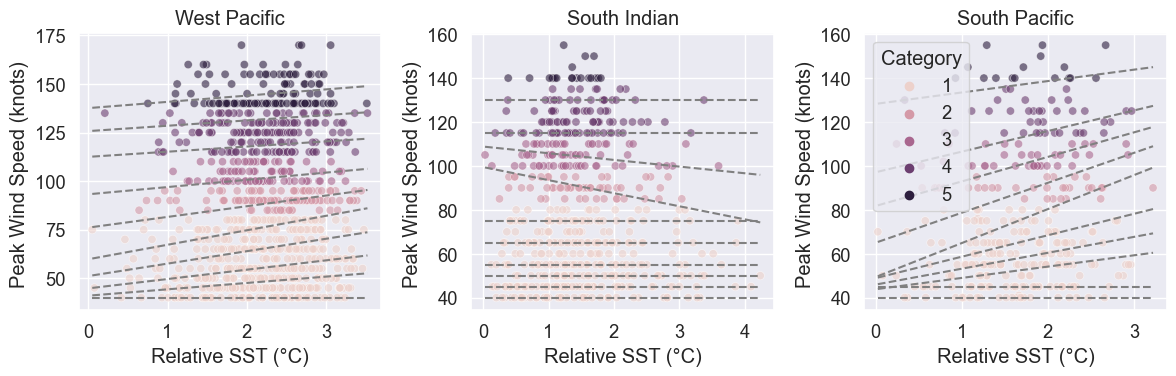

tropical_anomaly
 peak_vmax_kt  ~ tropical_anomaly
 peak_vmax_kt  ~ tropical_anomaly
 peak_vmax_kt  ~ tropical_anomaly


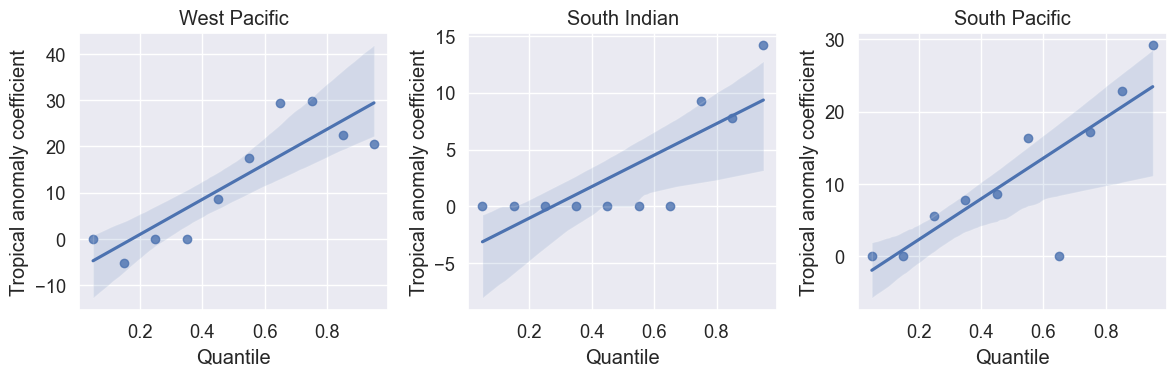

WP
 peak_vmax_kt  ~ tropical_anomaly
loss in basin: 10.052976241214724
SI
 peak_vmax_kt  ~ tropical_anomaly
loss in basin: 8.689098914422349
SP
 peak_vmax_kt  ~ tropical_anomaly
loss in basin: 8.584877246899335
total loss: 9.380436612512344


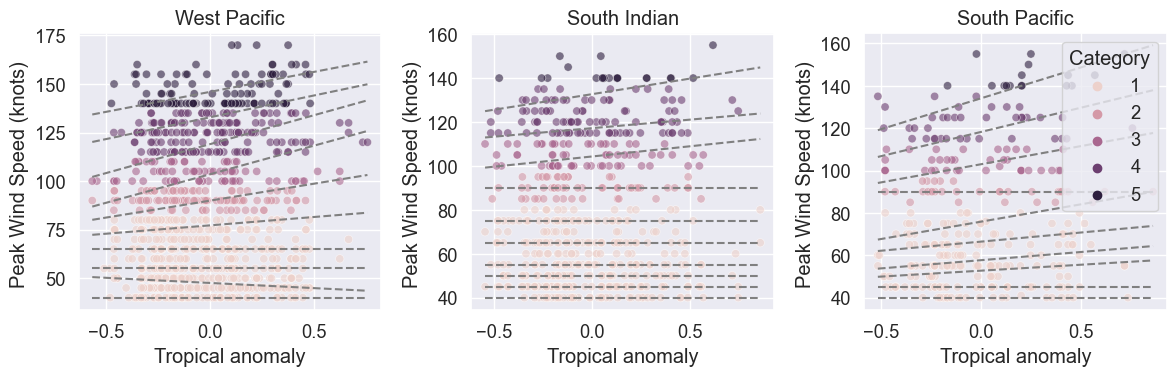

In [21]:
basin_name_map = {
    'SP': "South Pacific",
    'SI': "South Indian",
    "WP": "West Pacific"
}
all_vars = ['local_sst', 'tropical_sst', 'relative_sst', 'tropical_anomaly']
basin_dfs = {}

for ind_var in all_vars:
    print(ind_var)
    col=0
    fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
    for basin_name in renamed_df['basin'].unique():
        basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
        models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=[ind_var])
        plot_coefficients(models, ind_var=ind_var, ax=axs[col])
        axs[col].set_title(basin_name_map[basin_name])

        col += 1

    plt.tight_layout()
    plt.savefig(f'./media/freq_quantreg/new_basins/per_basin_{ind_var}_coefficients.png')
    plt.show()

    col=0
    fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
    total_loss = 0
    for basin_name in renamed_df['basin'].unique():
        print(basin_name)
        basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
        models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=[ind_var])

        basin_loss = get_loss(x=basin_df[ind_var], y=basin_df['peak_vmax_kt'], ind_var=ind_var, models=models)
        print(f'loss in basin: {basin_loss/basin_df.shape[0]}')
        total_loss += basin_loss
        plot_fit(basin_df, models, ind_var=ind_var, all_vars = [ind_var], response_var='peak_vmax_kt', ax=axs[col], add_legend = (col == 2))
        legend = axs[col].get_legend()
        if legend:
            legend.set(title='Category')
        axs[col].set_title(basin_name_map[basin_name])

        col += 1

    print(f'total loss: {total_loss/renamed_df.shape[0]}')

    plt.tight_layout()
    plt.savefig(f'./media/freq_quantreg/new_basins/per_basin_{ind_var}_fit.png')
    plt.show()


# col=0
# fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
# for basin_name in renamed_df['basin'].unique():
#     basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
#     models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['local_sst'])
#     plot_coefficients(models, ind_var='local_sst', response_var='peak_vmax_kt', ax=axs[col])

#     col += 1

# plt.tight_layout()
# plt.savefig('./media/freq_quantreg/new_basins/per_basin_local_sst_coefficients.png')
# plt.show()





# col=0
# fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4))
# for basin_name in renamed_df['basin'].unique():
#     basin_df = renamed_df.loc[renamed_df.loc[:, 'basin'] == basin_name ]
#     models = run_regression(basin_df, response_var='peak_vmax_kt', ind_vars=['local_sst'])
#     plot_fit(basin_df, models, ind_var='local_sst', all_vars=['local_sst'], response_var='peak_vmax_kt', ax=axs[col])
#     axs[col].get_legend().set(title='Category')
#     axs[col].set_title("hello")

#     col += 1

# plt.tight_layout()
# plt.savefig('./media/freq_quantreg/new_basins/per_basin_local_sst_fit.png')
# plt.show()


# for df in [si_renamed, sp_renamed, wp_renamed]:
#     run_regression_and_plots(df, response_var='peak_vmax_kt', ind_vars=['tropical_sst', 'local_sst'], title=f'peak vmax {df["basin"].unique()[0]}')
#     run_regression_and_plots(df, response_var='ace', ind_vars=['tropical_sst', 'local_sst'],title=f'ace {df["basin"].unique()[0]}')





    # GO THROUGH FOR EACH VARIABE AND PLOT SEPARATELY



    # regression_figs = plot_fits(df, models, ind_vars, response_var)

    # for regression_fig in regression_figs:
    #     fig = regression_fig['fig']
    #     filename = regression_fig['filename']
    #     if additional_title is not None:
    #         filename += "_" + additional_title
    #     plt.figure(fig)
    #     plt.savefig(filename + '.png')
    #     plt.show()

    # plot_fits(df, models, ind_vars, response_var)





